In [83]:
!pip3 install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


You should consider upgrading via the 'D:\projects\vsCode\pythonForHtests\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [84]:
!pip3 install -q "monai-weekly[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil,  openslide, pandas, einops, transformers, mlflow, matplotlib, tensorboardX, tifffile, imagecodecs]"

You should consider upgrading via the 'D:\projects\vsCode\pythonForHtests\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [85]:
!pip3 install h5py
!python -c "import matplotlib" || pip install -q matplotlib

You should consider upgrading via the 'D:\projects\vsCode\pythonForHtests\venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [86]:
import numpy as np

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,

)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import matplotlib.pyplot as plt


from monai.transforms import (
    LoadImage, LoadImaged, EnsureChannelFirstd,
    Resized,  Compose
)
from monai.config import print_config
import re


In [87]:
from monai.transforms import *

set_determinism(seed=0)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)


In [88]:
data_dir = "D:\\dataSets\\CTORGmini\\"

train_images = sorted(
    glob.glob(os.path.join(data_dir, "volumes 0-49", "*.nii.gz")))

train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labels", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
data_dicts

[{'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-20.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-20.nii.gz'},
 {'image': 'D:\\dataSets\\CTORGmini\\volumes 0-49\\volume-21.nii.gz',
  'label': 'D:\\dataSets\\CTORGmini\\labels\\labels-21.nii.gz'}]

In [89]:
def getNumberFromFilePath(dat):
    string = str(dat['image_meta_dict']['filename_or_obj'])
    numb = re.search('.nii', string).span()[0] ## this does what you wanted
    describingNumber = string[(numb-2):(numb)].replace("-","")
    return int(describingNumber)

In [90]:
# import h5py
# f = h5py.File("D:\\dataSets\\forMainHDF5\\smallLiverDataSet.hdf5", "w")

image shape: torch.Size([544, 419, 1720]), label shape: torch.Size([544, 419, 1720])


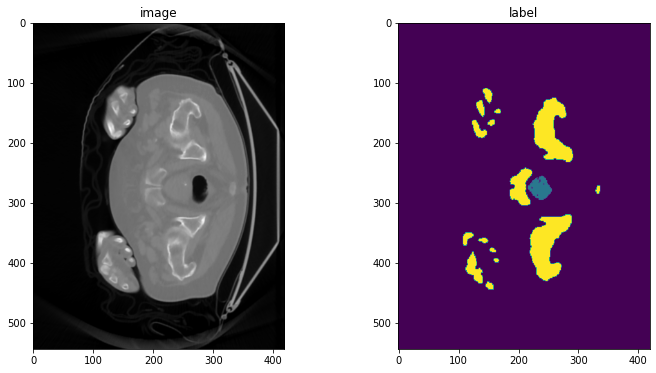

image shape: torch.Size([380, 281, 661]), label shape: torch.Size([380, 281, 661])


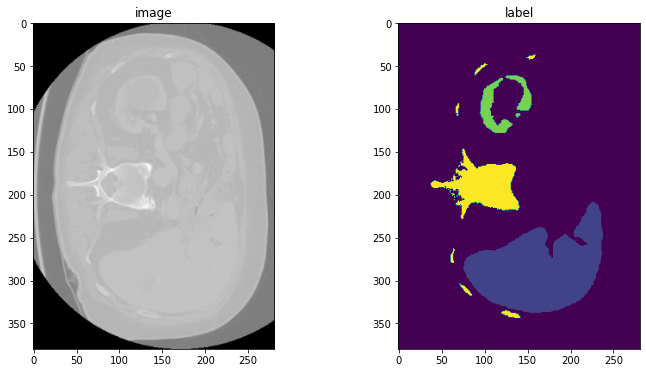

In [91]:
check_ds = Dataset(data=data_dicts, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for dat in check_loader:
    image= dat['image'][0,0,:,:]
    label=  dat['label'][0,0,:,:]
    middleSlice = round(label.size()[2]/2)
    print(f"image shape: {image.shape}, label shape: {label.shape}")
    # plot the slice [:, :, 80]
    plt.figure("check", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image[:, :, middleSlice], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title("label")
    plt.imshow(label[:, :, middleSlice])
    plt.show()


In [92]:
# check_ds = Dataset(data=data_dicts, transform=val_transforms)
# check_loader = DataLoader(check_ds, batch_size=1)

# for dat in check_loader:
#     describingNumber = getNumberFromFilePath(dat)
#     grp = f.create_group(str(describingNumber))

#     labelBoolTensor =torch.where( dat['label']==1, 1, 0).bool()
#     summ= torch.sum(labelBoolTensor)
#     #if summ>0:
#     labelBoolDataset = grp.create_dataset('liver', data=  (labelBoolTensor).detach().numpy())
#     imageDataset = grp.create_dataset('image', data=  (dat['image']).detach().numpy())
#     labelBoolDataset.attrs['sum']=  summ
    
#     imageDataset.attrs['dataType']=  "CT"
#     labelBoolDataset.attrs['dataType']=  "boolLabel"

#     #seting spacing - needs to be the same for all of the arrays in a grop - so the same for all images in patient
#     grp.attrs['spacing']=(1,1,1)

#     #get minimum and maximum values
#     imageDataset.attrs['min']=torch.min(dat['image'])
#     imageDataset.attrs['max']=torch.max(dat['image'])

#     labelBoolDataset.attrs['min']=0
#     labelBoolDataset.attrs['max']=1

  

#     print(describingNumber)
#     pass

In [93]:
f.close()

In [94]:
# filename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\volumes 0-49\\volume-21.nii.gz"
# biggestDat, meta = LoadImage()(filename)
# labelFilename = f"C:\\Users\\1\\Downloads\\volumes 0-49\\labels\\labels-21.nii.gz"
# biggestDatLabel, metaLabel = LoadImage()(labelFilename)
# biggestDatLabel


# image, label = (biggestDat[:,:,:], biggestDatLabel[:,:,:])
# print(f"image shape: {image.shape}, label shape: {label.shape}")
# # plot the slice [:, :, 80]
# plt.figure("check", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(image[:, :, 500], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[:, :, 500])
# plt.show()
# # torch.Size([544, 419, 1720])